In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import torchvision
from torchvision import datasets, models, transforms

In [3]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict
import itertools

In [4]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True

In [7]:
DATA_PATH = Path('C:/fastai/courses/dl2/data/road_damage_dataset')
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'
MULTIBB_CSV_PATH = DATA_PATH/'bb.csv'
files, mcs = ImageData.parse_csv_data(MULTICLASS_CSV_PATH)
files, mbbs = ImageData.parse_csv_data(MULTIBB_CSV_PATH)
mcs = [mc.split(' ') for mc in mcs]
classes = ["bg"] + sorted(list(set(itertools.chain.from_iterable(mcs))))
label2idx = {v:k for k,v in enumerate(classes)}
mcs = [[label2idx[c] for c in mc] for mc in mcs]
mbbs = [corners_to_center([int(x) for x in mbb.split(' ')]).tolist() for mbb in mbbs]

max_len = max([len(mc) for mc in mcs])

for mc, mb in zip(mcs, mbbs):
    mc += ([-1] * (max_len - len(mc)))
    mb += ([0] * (max_len * 4 - len(mb)))
    
    mc = np.array(mc)
    mb = np.array(mb)

In [8]:
imsize = 224
batch_size = 8
num_classes = 8

files = [DATA_PATH/file for file in files]
labels = [md.StructuredLabel([(cat, md.LabelType.CATEGORY, "CAT"), (bb, md.LabelType.BOUNDING_BOX, "BB")]) for bb, cat in zip(mbbs, mcs)]

train_tfms = TransformList([
    RandomScale(imsize, 1.1),
    RandomCrop(imsize),
    RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = TransformList([
    Scale(imsize),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

denorm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

i_dict = md.make_partition_indices(len(labels), {'train': .85, 'valid': .15})

datasets = {
    'train': ImageData.ImageDataset(util.mask(files, i_dict['train']), util.mask(labels, i_dict['train']), train_tfms),
    'valid': ImageData.ImageDataset(util.mask(files, i_dict['valid']), util.mask(labels, i_dict['valid']), val_tfms)
}  

data = md.ModelData(datasets, batch_size)

In [51]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)
    
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, x, bbox, clas=None, prs=None, thresh=0.3):
    im = np.moveaxis(x, 0, 2)
    bb = [center_to_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh) and c != 0):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += classes[c]
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
            
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, (bbox*imsize),
         clas, prs if prs is not None else None, thresh)

In [10]:
rawx,rawy,*_ = next(iter(data['train']))

In [11]:
x = rawx
y = {key: val.numpy() for key,val in rawy.items()}

In [12]:
y['BB'][0]

array([ 86.5, 175.5,  53. ,  77. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


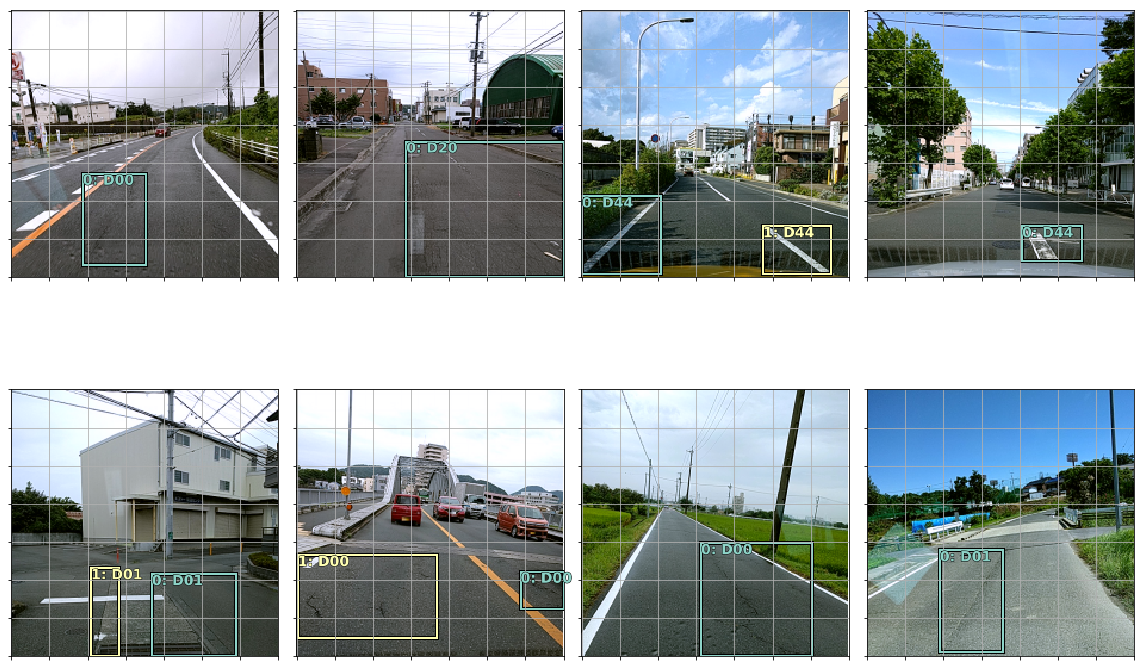

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, denorm(x[i]).numpy(), y['BB'][i], y['CAT'][i])
plt.tight_layout()

In [14]:
class StdConv(nn.Module):
    def __init__(self, n_in, n_out, stride=2, drop_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in, n_out, 3, stride=stride, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm = nn.BatchNorm2d(n_out)
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        return self.dropout(self.batch_norm(self.relu(self.conv(x))))

In [15]:
def flatten_conv(x,k=1):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class SSDOut(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.out_classes = nn.Conv2d(n_in, num_classes + 1, 3, padding=1) # Output for each class + background class
        self.out_boxes = nn.Conv2d(n_in, 4, 3, padding=1) # Output for bounding boxes
        
    def forward(self, x):
        return [flatten_conv(self.out_classes(x)), F.tanh(flatten_conv(self.out_boxes(x)))]

class SSDHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.conv_0 = StdConv(512, 256, stride=1)
        self.conv_1 = StdConv(256, 256)
        self.out = SSDOut(256)
        
    def forward(self, x):
        x = self.dropout(F.relu(x))
        x = self.conv_0(x)
        x = self.conv_1(x)
        return self.out(x)
        

In [16]:
model_ft = models.resnet18(pretrained=True)
layers = list(model_ft.children())[0:-2]
layers += [SSDHead()]
model = nn.Sequential(*list(layers))

In [17]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = util.to_gpu(Variable(torch.from_numpy(np.concatenate([anc_ctrs, anc_sizes], axis=1))).float())

grid_sizes = util.to_gpu(Variable(torch.from_numpy(np.array([1/anc_grid]))).unsqueeze(1).float())

In [18]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

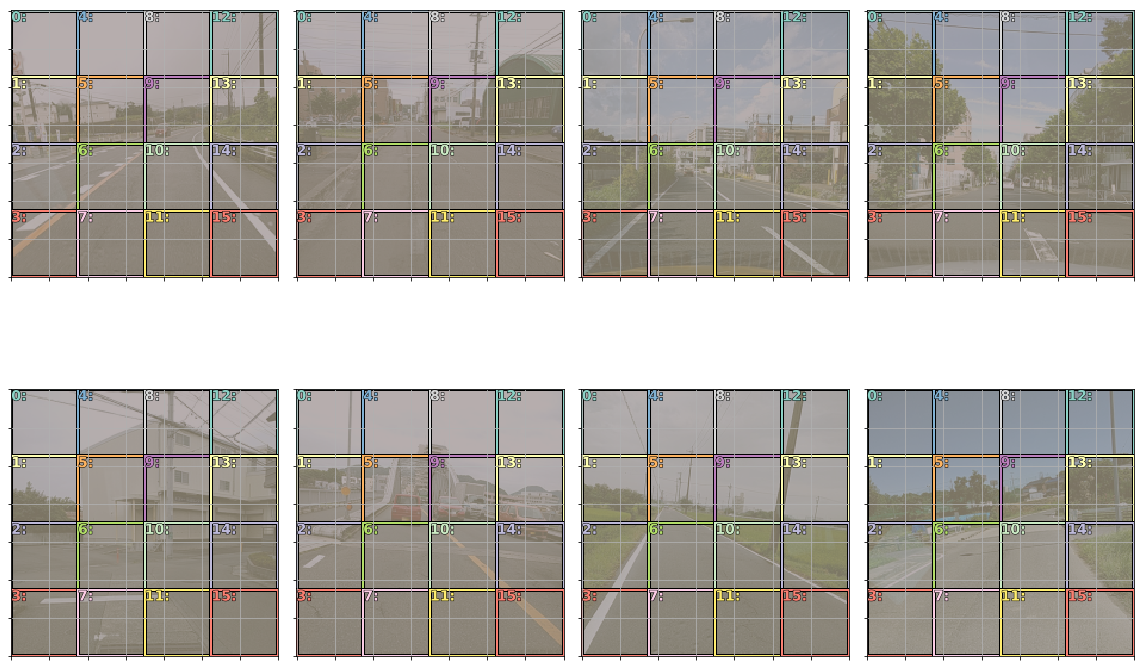

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, denorm(x[i]).numpy(), np.concatenate(anchors.data.cpu().numpy()) * 224)
plt.tight_layout()

In [20]:
def one_hot_embedding(labels, num_classes):
    ret = torch.eye(num_classes)[labels.data.long().cpu()]
    return ret

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, outputs, label):
        target = one_hot_embedding(label, self.num_classes+1) # +1 for background
        target = util.to_gpu(Variable(target[:,1:].contiguous())) # Ignore background and send to GPU
        pred = outputs[:,1:] # Get the models predicitons (no background)
        weight = self.get_weight(pred,target)
        return F.binary_cross_entropy_with_logits(pred, target, weight, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(num_classes)

In [21]:
def center_to_corners(bb): 
    x1 = bb[:,0] - bb[:,2] / 2
    y1 = bb[:,1] - bb[:,3] / 2
    x2 = bb[:,0] + bb[:,2] / 2
    y2 = bb[:,1] + bb[:,3] / 2
    return torch.stack([x1, y1, x2, y2], dim=1)

def intersect(box_a, box_b, log=False):
    if log: print("Intersect"); print("box_a: ", box_a); print("box_b: ", box_b)
        
    corn_a = center_to_corners(box_a)
    corn_b = center_to_corners(box_b)
    
    if log: print("corn_a: ", corn_a); print("corn_b: ", corn_b)
    
    max_xy = torch.min(corn_a[:, None, 2:].double(), corn_b[None, :, 2:].double())
    min_xy = torch.max(corn_a[:, None, :2].double(), corn_b[None, :, :2].double())
    
    if log: print("max_xy: ", max_xy); print("min_xy: ", min_xy)
    
    inter = torch.clamp((max_xy - min_xy), min=0)
    
    if log: print("inter: ", inter)
    
    return inter[:, :, 0] * inter[:, :, 1]

def box_size(b): return (b[:, 2] * b[:, 3]) # Input [_, _, width, height]

def jaccard(box_a, box_b, log=False):
    inter = intersect(box_a, box_b, log)
    union = box_size(box_a).double().unsqueeze(1) + box_size(box_b).double().unsqueeze(0) - inter
    return inter / union

In [35]:
"""
Remove padding from labels. 
Split concatenated bounding boxes into arrays of 4. 
Divide bounding box values by image size.
Labels are padded with -1s so they are the same shape and may be broadcast together in batches.
"""
def format_label(bbs, classes, log=False):
    if log: print("format_label"); print("bbs: ", bbs); print("classes: ", classes)
    bbs = bbs.view(-1,4)/imsize
    keep_idxs = (classes>-1).nonzero().view(-1)
    if log: print("Output"); print("bbs: ", bbs[keep_idxs]); print("classes: ", classes[keep_idxs])
    return bbs[keep_idxs], classes[keep_idxs]


""" 
Maps bounding box outputs to bounding boxes. 
The model's bounding box outputs are not bounding boxes and instead represent changes to the anchor boxes.  
"""
def map_bb_outputs_to_pred_bbs(outputs, anchors, log=False):
    if log: print("map_bb_outputs_to_pred_bbs"); print("outputs :", outputs); print("anchors :", anchors)
    
    # The first two values in the output represent a translation of the anchor box's center.
    # Grid size is the width and height of the anchor box
    # delta_center is bounded on the range (-grid_size / 2, grid_size / 2); 
    # that is, the center remains within the original bounding box. 
    delta_center = outputs[:,:2] / 2 * grid_sizes 
    
    if log: print("delta_center :", delta_center); print("grid_sizes :", grid_sizes)
    
    # The last two values in the output represent the width and height of the bounding box.
    # These values are interpreted as a precentage of the original anchor box's width and height.
    # percent_sizes is on the range (.5, 1.5). We add 1 since actn_bbs is on the range (-1, 1)
    percent_sizes = outputs[:,2:] / 2 + 1 
    
    if log: print("percent_sizes :", percent_sizes);
    
    actn_centers = delta_center + anchors[:,:2]  # Calculate predicted center_x and center_y  
    actn_wh = percent_sizes * anchors[:,2:]      # Calculate predicted width and height
    
    if log: print("returns :", torch.cat([actn_centers, actn_wh], dim=1));
    
    return torch.cat([actn_centers, actn_wh], dim=1)


def map_label_to_ground_truth(raw_label_bbs, raw_label_classes, anchors, log=False):
    label_bbs, label_classes = format_label(raw_label_bbs, raw_label_classes)
        
    if log: print("map_label_to_ground_truth"); print("label_bbs: ", label_bbs); print("label_classes: ", label_classes)
    
    overlaps = jaccard(label_bbs, anchors)
    
    if log: print("overlaps: ", overlaps)
    
    prior_overlap, prior_idx = overlaps.max(1)
    
    if log: print("prior_overlap: ", prior_overlap); print("prior_idx: ", prior_idx)
    
    gt_overlap, gt_idx = overlaps.max(0)
    
    if log: print("gt_overlap: ", gt_overlap); print("gt_idx: ", gt_idx)
    
    gt_overlap[prior_idx] = 1.99
    
    for i,o in enumerate(prior_idx): gt_idx[o] = i
        
    if log: print("gt_overlap: ", gt_overlap); print("gt_idx: ", gt_idx)
        
    gt_classes = label_classes[gt_idx]
    
    if log: print("gt_classes: ", gt_classes)
    
    matches = gt_overlap > 0.4
    
    if log: print("matches: ", matches)
    
    matching_idxs = torch.nonzero(matches)[:,0]
    
    if log: print("matching_idxs: ", matching_idxs)
    
    gt_classes[matches != 1] = 0
    
    gt_bbs = label_bbs[gt_idx]
    
    if log: print("gt_classes: ", gt_classes[matching_idxs]); print("gt_bbs: ", gt_bbs[matching_idxs]);
        
    return gt_bbs, gt_classes, matching_idxs


""" ssd loss for a single example """
def ssd_1_loss(pred_classes, bb_outputs, label_classes, label_bbs):      
    gt_bbs, gt_classes, matching_idxs = map_label_to_ground_truth(label_bbs, label_classes, anchors)
    
    pred_bbs = map_bb_outputs_to_pred_bbs(bb_outputs, anchors)
    
    loc_loss = ((pred_bbs[matching_idxs].float() - gt_bbs[matching_idxs].float()).abs()).mean()
    
    clas_loss  = loss_f(pred_classes, gt_classes)
    
    return loc_loss, clas_loss


""" ssd loss for a batch """
def ssd_loss(preds, target, log=False):
    total_location_loss = 0.
    total_class_loss = 0.
    
    for pred_clas, pred_bb, label_clas, label_bb in zip(*preds, target["CAT"], target["BB"]):
        
        loc_loss, clas_loss = ssd_1_loss(pred_clas, pred_bb, 
                                         label_clas, label_bb)
        
        total_location_loss += loc_loss
        total_class_loss += clas_loss
        
    if log: print(f'location: {total_location_loss.data[0]}, class: {total_class_loss.data[0]}')
        
    return total_location_loss + total_class_loss

In [ ]:
criterion = ssd_loss
optim_fn = optim.Adam
sess = Session(model, criterion, optim_fn, [*[1e-3] * 8, 1e-2])

In [49]:
def test():
    rawx, rawy, *_ = next(iter(data['valid']))
    pred_classes, bb_outputs = sess.forward(rawx)
    prints = {key: val.numpy() for key,val in rawy.items()}
    y = {key: Variable(util.to_gpu(value)) for key, value in rawy.items()}
    
    for i, x in enumerate(rawx):
        im = denorm(rawx[i]).numpy()
              
        pred_classes_1, bb_outputs_1 = pred_classes[i], bb_outputs[i]
        label_bbs, label_classes = y['BB'][i], y['CAT'][i]
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        show_ground_truth(axes.flat[0], im, prints['BB'][i], prints['CAT'][i])

        gt_bbs, gt_classes, *_ = map_label_to_ground_truth(label_bbs, label_classes, anchors)
        torch_gt(axes.flat[1], im, anchors.cpu().data.numpy(), gt_classes.cpu().data.numpy())

        torch_gt(axes.flat[2], im, anchors.cpu().data.numpy(), pred_classes_1.max(1)[1].data)

        a_ic = map_bb_outputs_to_pred_bbs(bb_outputs_1, anchors)
        torch_gt(axes.flat[3], im, a_ic.cpu().data.numpy(), pred_classes_1.max(1)[1].data, pred_classes_1.max(1)[0].sigmoid().data, thresh=0.0)

In [23]:
test()

In [40]:
sess.step(rawx, rawy)

72.0545883178711

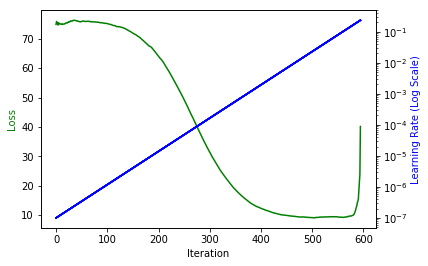

In [41]:
lr_find(sess, data['train'], start_lr=1e-7)

In [42]:
sess.set_lr([*[1e-4 / 2] * 8, 1e-4])

In [43]:
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
validator = Validator(data['valid'])
schedule = TrainingSchedule(data['train'], [lr_scheduler, validator])

sess.train(schedule, 7)

Training Loss: 7.166121  Validaton Loss: 7.047295 Validation Accuracy: 0.000000


Training Loss: 6.763837  Validaton Loss: 6.810147 Validation Accuracy: 0.000000


Training Loss: 5.777564  Validaton Loss: 5.835093 Validation Accuracy: 0.000000


Training Loss: 6.337848  Validaton Loss: 6.781007 Validation Accuracy: 0.000000


Training Loss: 5.870970  Validaton Loss: 6.054122 Validation Accuracy: 0.000000


Training Loss: 5.193823  Validaton Loss: 5.246509 Validation Accuracy: 0.000000


Training Loss: 4.738223  Validaton Loss: 5.110192 Validation Accuracy: 0.000000


In [44]:
sess.save('ssd_2')

In [45]:
sess.load('ssd_2')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

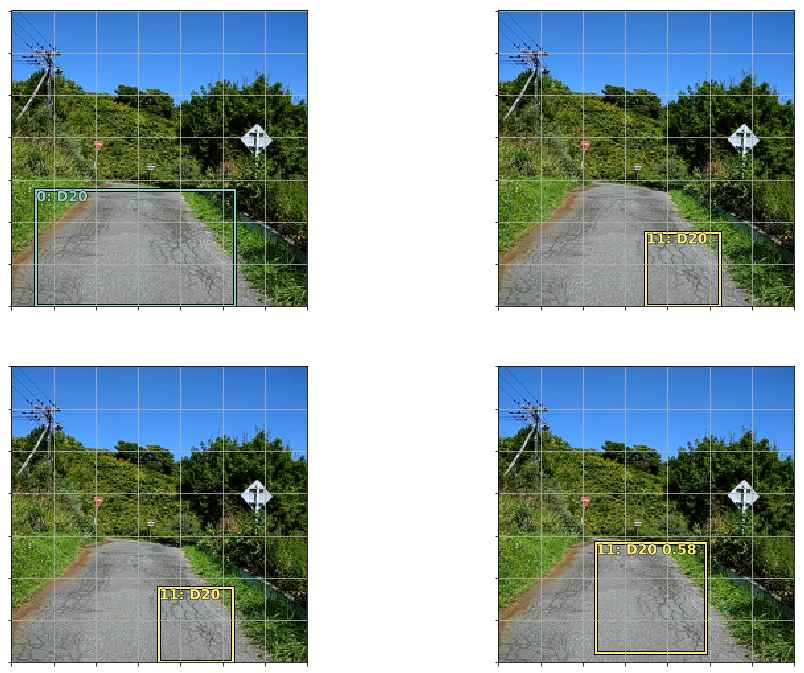

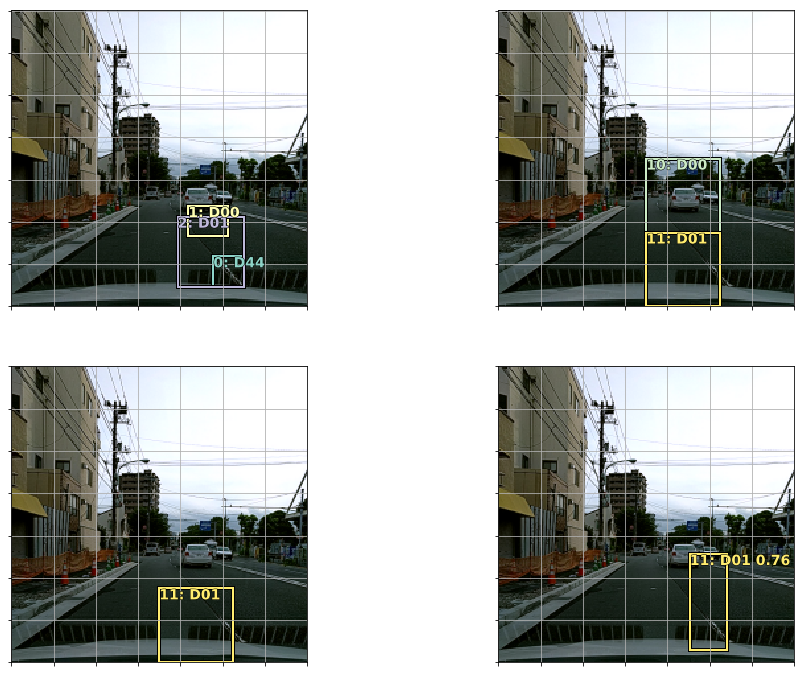

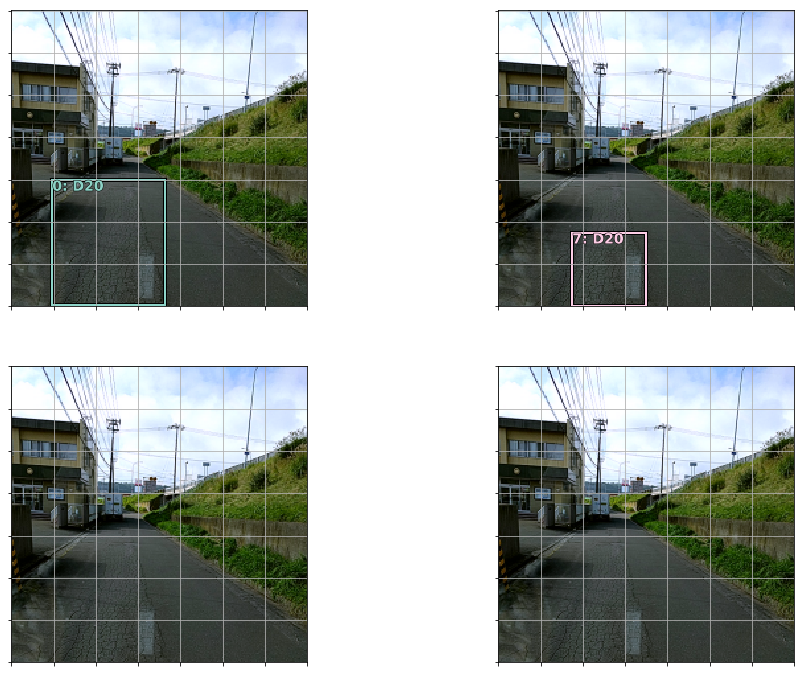

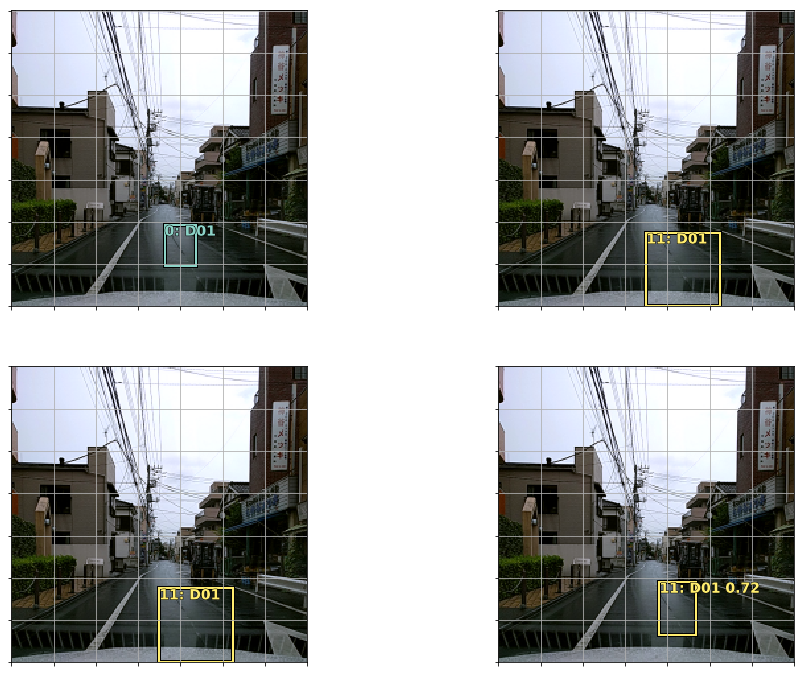

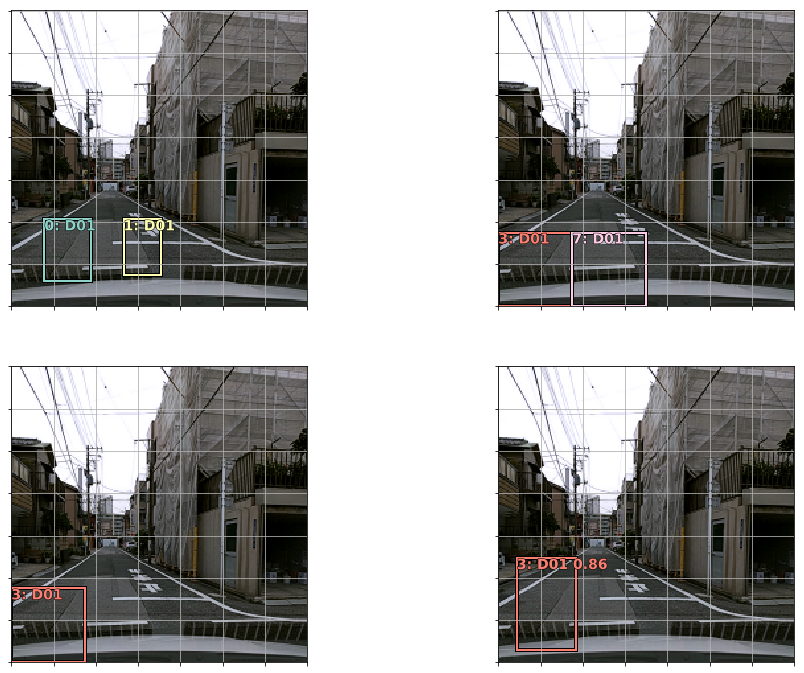

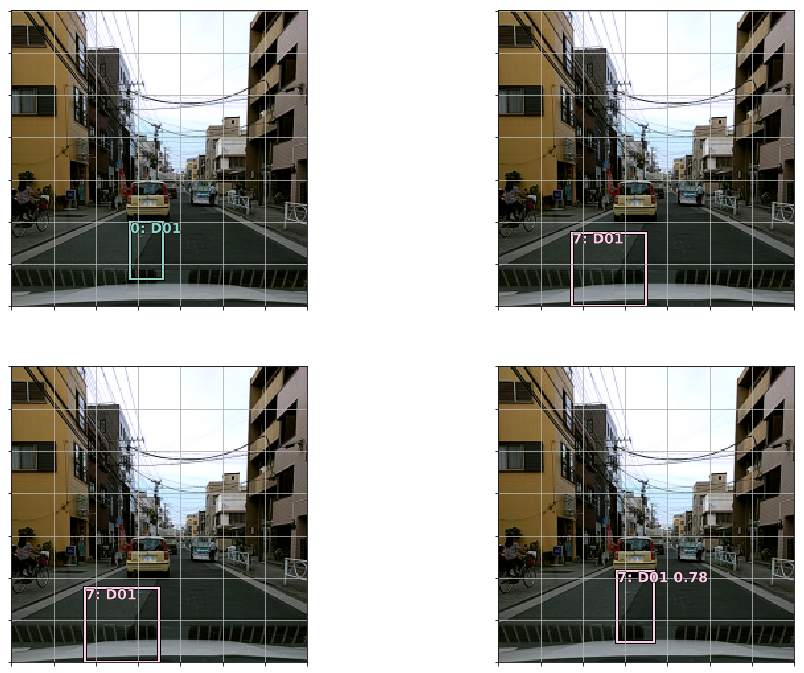

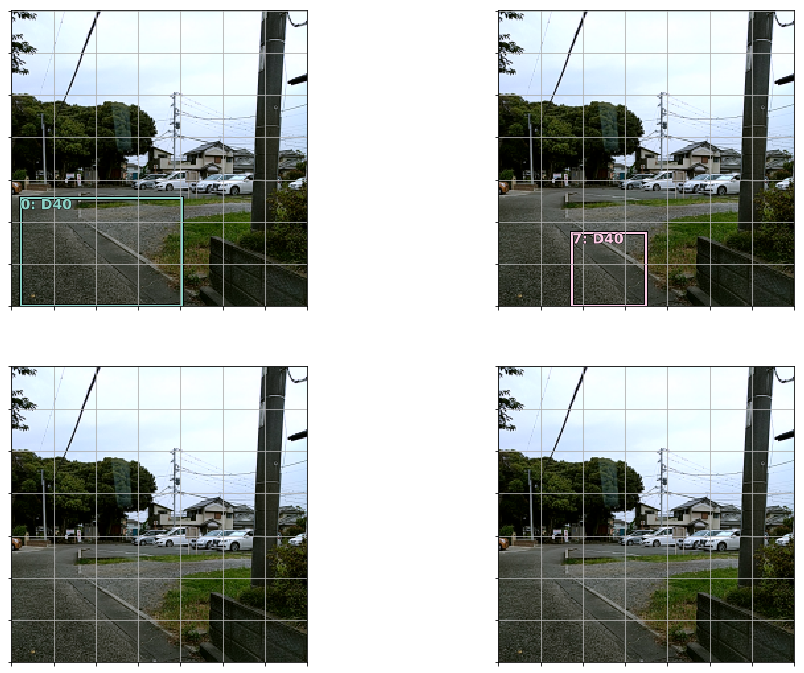

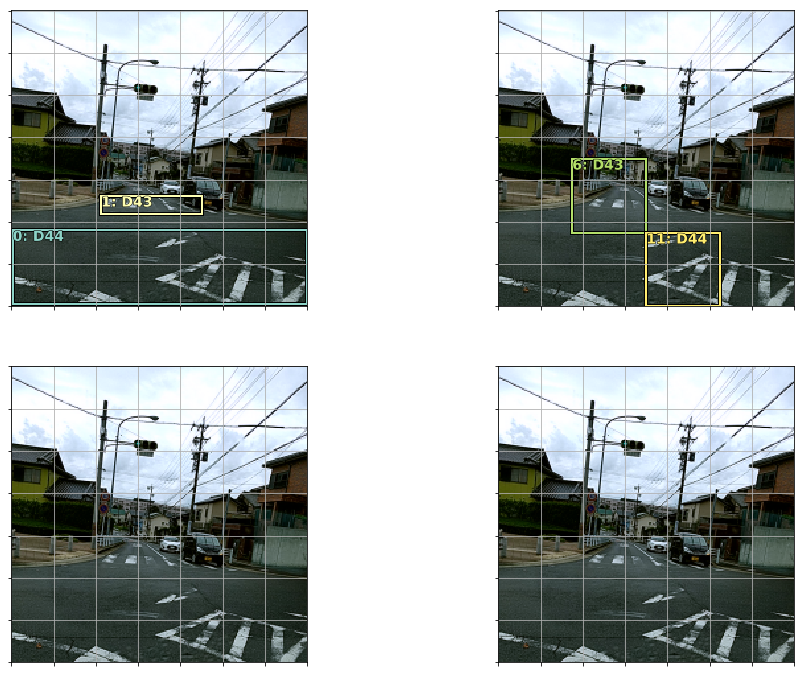

In [52]:
test()